#  Covid test data for Devon

### Data availability

Data on Covid is available for the UK from https://coronavirus.data.gov.uk/details/download.  

* For England as a whole: daily case data is available (including people who have had at least one positive COVID-19 test result). In this, data are shown by the date the sample was taken from the person being tested. Definition at: https://coronavirus.data.gov.uk/metrics/doc/newCasesBySpecimenDate  

* For MSOAs: weekly case data is available, showing the number of new cases within a 7 day period. Definition at https://coronavirus.data.gov.uk/metrics/doc/newCasesBySpecimenDateRollingSum

Additionally, daily case data at MSOA level is available that was downloaded at a previous date (?). This data does not include dates, but instead day numbers starting from 0. Day 0 is believed to equate to the 1st April 2020.  

### Script functionality
This script compares the weekly case data from the government website, with the daily case data (previously downloaded from government website?).  
Plots cases over time for both the whole of Devon and for individual MSOAs.  


### Conclusions
'Daily data' wasn't actually raw case data as thought, but created by Hadren in script at https://github.com/Urban-Analytics/RAMP-UA/blob/Ecotwins-withCommuting/lab/createSeedingFiles.R

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import datetime
import matplotlib.dates as mdates
import numpy as np  

# Case data - individual MSOAs
## Weekly case data
### Download COVID test data for the UK from government website

In [2]:
# define url to get data from
new_url = 'https://api.coronavirus.data.gov.uk/v2/data?areaType=msoa&metric=newCasesBySpecimenDateRollingSum&metric&format=csv'
df = pd.read_csv(new_url)

# And filter to time period
start, end = "2020-04-01", "2020-12-12"
query_string = 'date >= "{}" & date <= "{}"'.format(start, end)
df = df.query(query_string)

### Reformat date and keep only data for MSOAs in Devon

In [24]:
weekly_cases_msoas =df.copy()

# rename column to MSOA11CD
weekly_cases_msoas.rename(columns={"areaCode": "MSOA11CD", "date": "Date"}, inplace = True)

# set MSOA codes as index
weekly_cases_msoas = weekly_cases_msoas.set_index('MSOA11CD', drop=True)

# Reverse order of data (was starting from most recent date)
weekly_cases_msoas = weekly_cases_msoas.iloc[::-1]

# Convert to datetime (and then to just date)
weekly_cases_msoas['Date'] = pd.to_datetime(weekly_cases_msoas['Date'], format='%Y-%m-%d').dt.date
# Order by date
weekly_cases_msoas.sort_values(by='Date', inplace =True)

######### Just devon
# Load csv containing codes of msoas in Devon
devon_msoa_codes =pd.read_csv("devon_msoa_codes.csv").set_index('MSOA11CD', drop=True,verify_integrity=True)

# Keep only MSOA codes in Devon
weekly_cases_msoas = weekly_cases_msoas.join(other=devon_msoa_codes, how="inner")

# Keep only relevant columns
weekly_cases_msoas = weekly_cases_msoas[['Date', 'newCasesBySpecimenDateRollingSum']]

weekly_cases_msoas.head()

,Date,newCasesBySpecimenDateRollingSum
MSOA11CD,,
E02004129,2020-10-27,3
E02004129,2020-11-03,3
E02004129,2020-11-10,7
E02004129,2020-11-17,7
E02004129,2020-11-24,4


### Convert format
Previous format: 2 columns, one with dates, one with cases numbers, MSOA code as index  
New format: One column with date, column for each MSOA containing cases numbers on each date

In [25]:
# Create dataframe containing the dates for which there are data in at least one MSOA
dates = pd.DataFrame({'Date':weekly_cases_msoas['Date'].unique()})
# Create list to store dataframe for each MSOA
list_dfs = []
# Loop through MSOAs and convert the format into a dataframe with a column for dates and a column for case values in that MSOA
# Join it to the list of dates with data in any MSOA
# Add to list of dataframes
for msoa_code in weekly_cases_msoas.index.unique().values:
    # get data for just one MSOA
    one_msoa = weekly_cases_msoas[weekly_cases_msoas.index ==msoa_code ]
    #print(one_msoa)
    # Create column as well as index (needed in pivot?)
    one_msoa.reset_index(level=0, inplace=True)
    # Pivot the format of the data so...
    piv = one_msoa.pivot(index = 'MSOA11CD', columns = 'Date')['newCasesBySpecimenDateRollingSum']
    # Transpose it so...
    piv_t = piv.T
    piv_t.reset_index(drop = False, inplace = True)
    # Join to dates
    piv_t = pd.merge(dates, piv_t, on=["Date"], how = 'left')
    if not list_dfs:
        list_dfs.append(piv_t)
    else:
        list_dfs.append(piv_t[msoa_code])
        
# Join list of dataframes into one        
weekly_cases_msoas = pd.concat(list_dfs, axis=1)
# Sort by date
weekly_cases_msoas.sort_values(by='Date', inplace =True)

weekly_cases_msoas = weekly_cases_msoas[0:53].reset_index(drop = True)
weekly_cases_msoas.head()

,Date,E02004129,E02004130,E02004131,E02004132,E02004133,E02004134,E02004135,E02004136,E02004137,...,E02004226,E02004227,E02004228,E02004229,E02004230,E02004231,E02004232,E02004233,E02004234,E02004235
0,2020-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,NaN
1,2020-04-14,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,...,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-04-21,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,9.0,NaN,NaN,NaN,NaN,NaN,4.0,9.0,NaN
3,2020-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,3.0,NaN,NaN,4.0,3.0,NaN
4,2020-05-05,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Replace NaNs with 0  
This is where individual MSOAs didn't have data for some of the dates in the period

In [26]:
weekly_cases_msoas = weekly_cases_msoas.fillna(0)

# Data for whole of Devon combined

Create a dataframe containing info on cases across the WHOLE of Devon, with:  
* One column with dates
* One column with the number of new cases on each date
* One column with the cumulative number of cases so far on that date

### Find total number of cases over whole of Devon

In [28]:
def find_devon_totals(df):
    totals_df = df.copy()
    # Add a row with the total number of cases across all MSOAs in each day
    totals_df['Total_obs']= totals_df.iloc[:, 1:].sum(axis=1)
    # Remove columns with individual values for each MSOA
    totals_df = totals_df.drop(totals_df.iloc[:, 1:-1].columns, axis=1)
    totals_df.reset_index(inplace = True, drop = True)
    # Find the cumulative cases
    totals_df['CumulativeCases'] = totals_df['Total_obs'].cumsum()
    # Rename column
    totals_df.rename(columns={"Total_obs": "Cases"}, inplace = True)
    # Sort by date
    totals_df.sort_values(by='Date', inplace =True)
    return totals_df
    
weekly_cases_devon = find_devon_totals(weekly_cases_msoas) 
weekly_cases_devon.head()

,Date,Cases,CumulativeCases
0,2020-04-07,75.0,75.0
1,2020-04-14,82.0,157.0
2,2020-04-21,90.0,247.0
3,2020-04-28,96.0,343.0
4,2020-05-05,84.0,427.0


## Download daily case data for whole of Devon

In [32]:
# define url to get data from
# new_url = 'https://api.coronavirus.data.gov.uk/v2/data?areaType=msoa&metric=newCasesBySpecimenDateRollingSum&metric&format=csv'
new_url = 'https://api.coronavirus.data.gov.uk/v2/data?areaType=utla&areaCode=E10000008&metric=newCasesBySpecimenDate&format=csv'
downloaded_weekly_cases_devon = pd.read_csv(new_url)
# And filter to time period
start, end = "2020-04-01", "2020-12-12"
query_string = 'date >= "{}" & date <= "{}"'.format(start, end)
downloaded_weekly_cases_devon = downloaded_weekly_cases_devon.query(query_string)

### Sum up to weekly data

In [62]:
downloaded_weekly_cases_devon = downloaded_weekly_cases_devon[['date', 'newCasesBySpecimenDate']]
downloaded_weekly_cases_devon.sort_values(by='date', inplace =True)
downloaded_weekly_cases_devon.reset_index(inplace=True, drop =True)
# Sum up weekly
column_operations = {'date': 'last', "newCasesBySpecimenDate": 'sum'}
downloaded_weekly_cases_devon_daily = downloaded_weekly_cases_devon.groupby(downloaded_weekly_cases_devon.index // 7).agg(column_operations)
# Format date
downloaded_weekly_cases_devon_daily['Date'] = pd.to_datetime(downloaded_weekly_cases_devon_daily['date'], format='%Y-%m-%d').dt.date
downloaded_weekly_cases_devon_daily.head()

,date,newCasesBySpecimenDate,Date
0,2020-04-07,157,2020-04-07
1,2020-04-14,161,2020-04-14
2,2020-04-21,163,2020-04-21
3,2020-04-28,162,2020-04-28
4,2020-05-05,148,2020-05-05


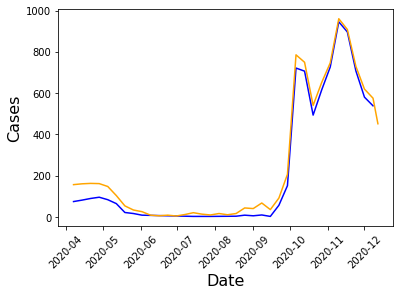

In [64]:
# shared axis
fig, ax = plt.subplots()
plt.xlabel("Date", fontsize= 16)
plt.ylabel("Cases", fontsize= 16)
# plt.title("n")
plt.xticks(rotation=45)
plt.plot(weekly_cases_devon['Date'], weekly_cases_devon['Cases'], label="Shifted cases", color="blue")
plt.plot(downloaded_weekly_cases_devon_daily['Date'], downloaded_weekly_cases_devon_daily['newCasesBySpecimenDate'], label="Shifted cases", color="orange")